# Big project activity

## Optimal chargin station location

### 1.Introduction

Consider a long linear cycle path  as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots,n\}$ corresponds to the tourist sites that may host a charging station.
In addition we are given the distances between touristic site ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots,n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destination in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number but it is an unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each  arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constrain is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate you choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1: Andrea Cerutti

ID1: 10742171

student2:

ID2:

student3

ID3:



In [19]:
#install libraries

!pip install mip
!pip install --upgrade cffi==1.15.0

In [3]:
#import libraries

import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
#IMPORT THE CSV FILES

import pandas as pd
from IPython.display import display




# load the nodes from the node.csv file
nodes = pd.read_csv('nodes.csv', encoding='unicode_escape')

# display first part and shape of the csv file
display(nodes.head())
print(nodes.shape)




# load the arcs from the node.csv file
arcs = pd.read_csv('OD.csv', encoding='unicode_escape')

# We set the distance between a node and himself to an high value to ensures that
# no self-loop will be selected
arcs.fillna(10000000., inplace=True)
# display first part and shape of the csv file
display(arcs.head())
print(arcs.shape)



,tourist_dest_id,Comune,Piazza,x (longitude),y (latitude),Cost_of_installation []
0,0,Piacenza,Piazza dei Cavalli,9.693077,45.052685,1784
1,17,Cremona,Piazza Duomo,10.024813,45.133448,1922
2,18,Gerre de' Caprioli,Piazza del Comune,10.040384,45.105451,1559
3,20,Stagno Lombardo,Piazza Roma,10.087919,45.073051,1969
4,21,Pieve d'Olmi,NaN,10.135646,45.071680,1621


(44, 6)


,origin_id,destination_id,total_cost
0,0,0,1.000000e+07
1,0,17,4.379808e+04
2,0,18,4.725299e+04
3,0,20,5.717188e+04
4,0,21,6.226057e+04


(1936, 3)


In [5]:
#set the timer

from datetime import datetime
import pytz

starting_time = datetime.now(pytz.timezone('Europe/Rome'))

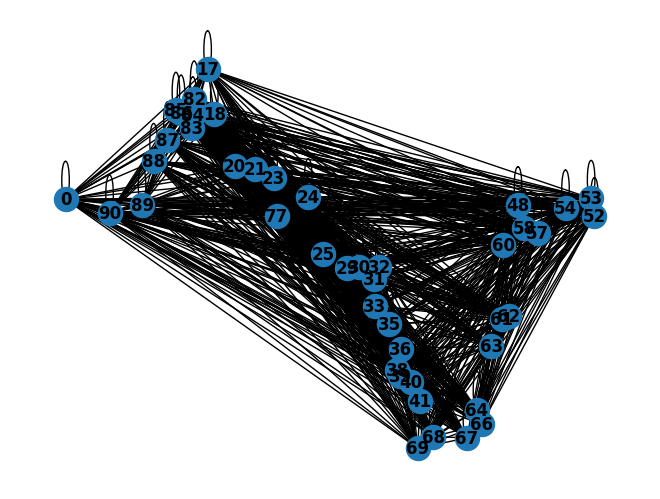

In [6]:
#build the equivalent graph

#define the set of nodes

nodes_np = nodes.to_numpy()
N = []
for node in nodes_np:
  N.append(node[0])

#define the set of edges

arcs_np = arcs.to_numpy()

A = []
for arc in arcs_np:
  A.append((arc[0], arc[1]))

#plot the graph

coord = {i[0]: (i[3], i[4]) for i in nodes_np}

g = nx.Graph()
g.add_nodes_from(N)
g.add_edges_from(A)

#nx.draw(g, pos=coord)
nx.draw(g, pos=coord, with_labels=True, font_weight='bold')


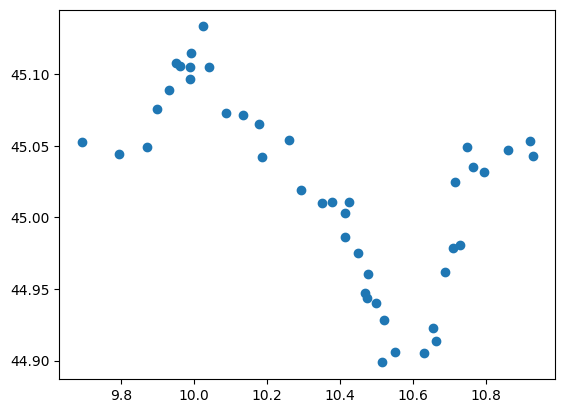

In [7]:
# station positions:
plt.scatter(nodes_np[:,3], nodes_np[:,4])
plt.show()


In [8]:
import mip




# CREATE THE MODEL
m = mip.Model()



# SETS

# A_dummy contains all the arcs plus all the arcs that connects the dummy node
# to and from all other nodes. We are making the problem cyclic, we will start
# and finish in the dummy node
dummy = [(-1,i) for i in N] + [(i,-1) for i in N] + [(-1,-1)]
A_dummy = A + dummy

# N_dummy is the set of nodes unified with the dummy node -1
N_dummy = N + [-1]




# PARAMETERS

# The distances are taken from the OD node
distances = {(a[0], a[1]):a[2] for a in arcs_np }
# Add the dummy nodes in the arcs distances, set the distances between the node and
# itself to an high value to avoid selecting the path from the dummy node to itself
for el in N:
  distances[(-1,el)] = 0.
  distances[(el,-1)] = 0.
distances[-1,-1] = 1000000000000.




# VARIABLES

# The variables of the problem are the edges (couples of consecutive active charging stations)
X = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in A_dummy} #empty variables




# CONSTRAINTS

# conservation constraint
for i in N_dummy:
  m.add_constr(mip.xsum(X[i,j] for j in N_dummy)-mip.xsum(X[j,i] for j in N_dummy)==0)

# start avoiding loop with just two elements
for i in N_dummy:
  for j in N_dummy:
    m.add_constr(X[i,j] + X[j,i]<=1)

# All stations are active so they have at least an arc that exits from them
for i in N_dummy:
  m.add_constr(mip.xsum(X[i,j] for j in N_dummy)==1)
# for j in N_dummy:
#   m.add_constr(mip.xsum(X[j, i] for i in N_dummy)==1)




# OBJECTIVE FUNCTION
m.objective = mip.minimize(mip.xsum(X[i,j]*distances[(i,j)] for (i,j) in A_dummy))

229220.7569767
subset:  22 [(17.0, 86.0), (86.0, 85.0), (85.0, 87.0), (87.0, 88.0), (88.0, 89.0), (89.0, 90.0), (90.0, 0.0), (0, -1), (-1, 35), (35.0, 33.0), (33.0, 32.0), (32.0, 31.0), (31.0, 30.0), (30.0, 29.0), (29.0, 25.0), (25.0, 24.0), (24.0, 77.0), (77.0, 23.0), (23.0, 21.0), (21.0, 20.0), (20.0, 18.0), (18.0, 17.0)]
subset:  4 [(36.0, 40.0), (40.0, 39.0), (39.0, 38.0), (38.0, 36.0)]
subset:  3 [(41.0, 68.0), (68.0, 69.0), (69.0, 41.0)]
subset:  3 [(48.0, 57.0), (57.0, 58.0), (58.0, 48.0)]
subset:  3 [(52.0, 53.0), (53.0, 54.0), (54.0, 52.0)]
subset:  4 [(60.0, 62.0), (62.0, 61.0), (61.0, 63.0), (63.0, 60.0)]
subset:  3 [(64.0, 66.0), (66.0, 67.0), (67.0, 64.0)]
subset:  3 [(82.0, 84.0), (84.0, 83.0), (83.0, 82.0)]


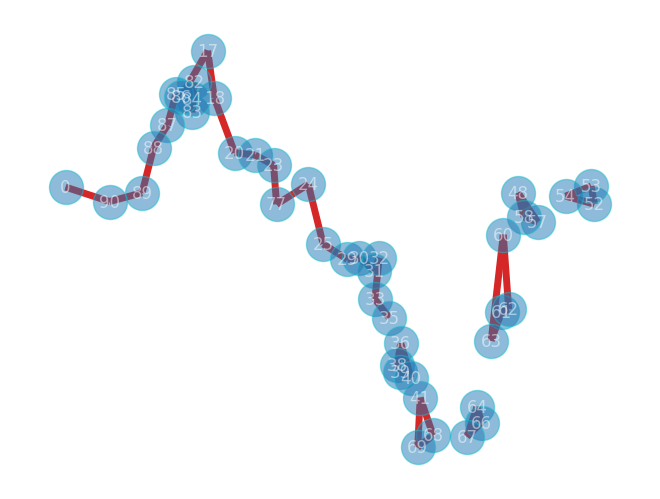

229220.7569797
subset:  22 [(17.0, 86.0), (86.0, 85.0), (85.0, 87.0), (87.0, 88.0), (88.0, 89.0), (89.0, 90.0), (90.0, 0.0), (0, -1), (-1, 35), (35.0, 33.0), (33.0, 31.0), (31.0, 32.0), (32.0, 30.0), (30.0, 29.0), (29.0, 25.0), (25.0, 24.0), (24.0, 77.0), (77.0, 23.0), (23.0, 21.0), (21.0, 20.0), (20.0, 18.0), (18.0, 17.0)]
subset:  4 [(36.0, 39.0), (39.0, 40.0), (40.0, 38.0), (38.0, 36.0)]
subset:  3 [(41.0, 69.0), (69.0, 68.0), (68.0, 41.0)]
subset:  3 [(48.0, 58.0), (58.0, 57.0), (57.0, 48.0)]
subset:  3 [(52.0, 54.0), (54.0, 53.0), (53.0, 52.0)]
subset:  4 [(60.0, 61.0), (61.0, 62.0), (62.0, 63.0), (63.0, 60.0)]
subset:  3 [(64.0, 67.0), (67.0, 66.0), (66.0, 64.0)]
subset:  3 [(82.0, 83.0), (83.0, 84.0), (84.0, 82.0)]


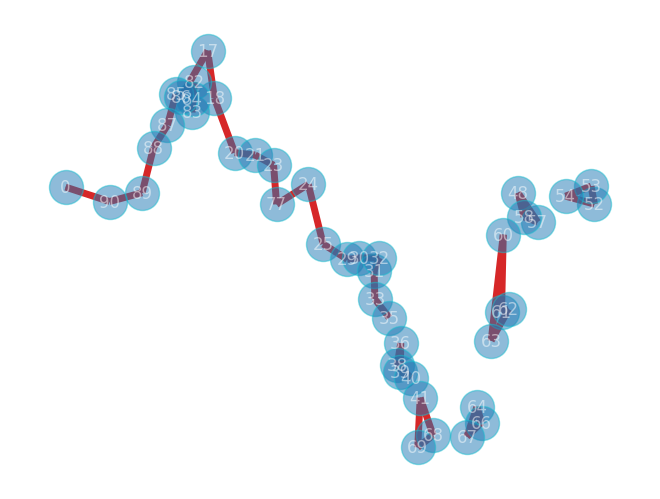

238507.22819670005
subset:  45 [(17.0, 83.0), (83.0, 84.0), (84.0, 82.0), (82.0, 86.0), (86.0, 85.0), (85.0, 87.0), (87.0, 88.0), (88.0, 89.0), (89.0, 90.0), (90.0, 0.0), (0, -1), (-1, 52), (52.0, 53.0), (53.0, 54.0), (54.0, 57.0), (57.0, 58.0), (58.0, 48.0), (48.0, 60.0), (60.0, 62.0), (62.0, 61.0), (61.0, 63.0), (63.0, 66.0), (66.0, 64.0), (64.0, 67.0), (67.0, 68.0), (68.0, 69.0), (69.0, 41.0), (41.0, 40.0), (40.0, 39.0), (39.0, 38.0), (38.0, 36.0), (36.0, 35.0), (35.0, 33.0), (33.0, 32.0), (32.0, 31.0), (31.0, 30.0), (30.0, 29.0), (29.0, 25.0), (25.0, 24.0), (24.0, 77.0), (77.0, 23.0), (23.0, 21.0), (21.0, 20.0), (20.0, 18.0), (18.0, 17.0)]


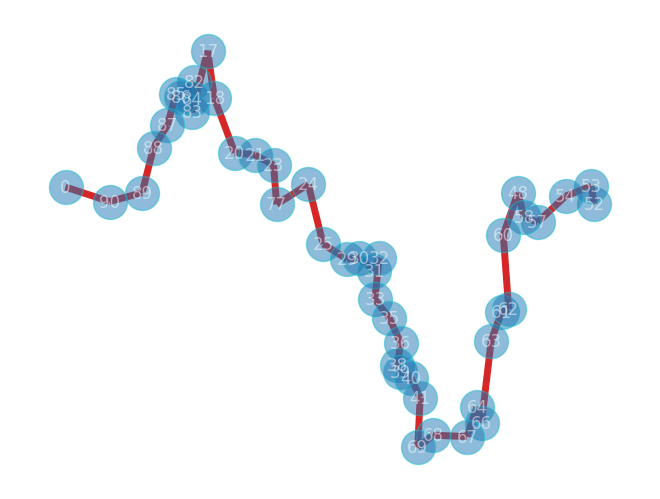

In [9]:
## PROBLEM 1 FIND THE OPTIMAL PATH


def get_subset(input, cur: tuple):
  """
  Obtain a subset of elements which are part of a cycle while removing such elements from the given input.

  :param input: The input list of arcs.
  :param cur: A tuple representing the starting arc.
  :return: A list containing the removed arcs.
  """
  next = None
  # find the arc following the current one
  for el in input:
    # found
    if el[0] == cur[1]:
      # assign it to next
      next = el
  # if it has next, we are still in the cycle, otherwise it is the last arc
  if next:
    # remove arc that may be in cycle
    input.remove(cur)
    # add it to the returned set of arcs
    return [cur] + get_subset(input, next)
  # remove last cycle arc
  input.remove(cur)
  # return last cycle arc
  return [cur]



cycle = True
count = 0;
sol = []

# Repeat when the solution of the optimization will contain a cycle and not a path
while cycle:
  # Find the minimum cost arc such that all nodes are connected to some other nodes
  m.optimize()
  print(m.objective_value)
  sol = []
  for (i,j) in A_dummy:
    if X[i,j].x:
      sol.append((i,j))
  # use a copy of the solution to remove cycles iteratively
  sol_copy = sol.copy()

  # if not every node of the solution has been hexamined
  while sol_copy:

    # extract and remove from the solution the next subset of nodes forming a
    # cycle
    subset = get_subset(sol_copy, sol_copy[0])
    print('subset: ', len(subset), subset)
    # if the returned subset is as big as the total number of nodes
    # (including dummy) exit
    if len(subset) == len(N_dummy):
      cycle = False
    else:
      # add the constraint that the sum of the distances in the subset must be
      # less than the cycle length, in order to remove the cycle
      m.add_constr(mip.xsum(X[sel] for sel in subset) <= len(subset) - 1)


  g = nx.Graph()
  g.add_nodes_from(N)
  sol_filtered = [x for x in sol if x[0] != -1 and x[1] != -1]
  g.add_edges_from(sol_filtered)
  options = {"edgecolors": "tab:cyan", "node_size": 600, "alpha": 0.5}
  nx.draw(g, pos=coord, with_labels=True, font_color='white', **options)
  nx.draw_networkx_edges(g, pos=coord, edge_color="tab:red", width=5.0)
  plt.show()

In [10]:
# define the distances in a dictionary:
# returns the distance between two points using recursion
def get_distance(start: int, stop: int) -> (float, dict):
  if start == stop:
    return 0.
  for el in sol:
    if el[0] == start:
      next = el[1]
  return distances[(start,next)] + get_distance(next, stop)


# get the last and first nodes
for el in sol:
  if el[0] == -1:
    start = el
  if el[1] == -1:
    end = el
# creates a dictionary, the node i s the key, the cost of installation is the value
c = {node[0]: node[5] for node in nodes_np}
c[-1] = 0.
# create a dictionary and uses the arcs (i,j) as keys and the distances between i and j as the value
real_distances = {}
for i in N_dummy:
  for j in N_dummy:
    real_distances[(i,j)] = get_distance(i,j)


def calculate_model(b: int, arcs: list, nodes: list, N: list):
  # Create model
  m = mip.Model()

  # define the variables

  # The variables of the problem are the edges (couples of consecutive active charging stations)
  X = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in arcs} #empty variables
  Y = m.add_var()

  #  define the contraints
  for i in nodes:
    m.add_constr(mip.xsum(X[i,j] for j in nodes)-mip.xsum(X[j,i] for j in nodes)==0) # flow conservation
  # dummy station is active
  m.add_constr(mip.xsum(X[-1,i] for i in N)==1) # arc from dummy to the first node and arc from the last node to dummy needs to be active
  m.add_constr(mip.xsum(X[i,-1] for i in N)==1)
  # Y is limited greater than the maximum distance
  for (i,j) in arcs:
    m.add_constr(X[i,j] * real_distances[(i,j)]<= Y) # the length of every arc in the solution is lessa than Y
  # the budget is met
  m.add_constr(mip.xsum(X[i,j]*c[i] for (i,j) in arcs) - b<=0) # cost less than budget

  # optimize objective function
  m.objective = mip.minimize(Y)

  return {"model": m, "arcs": X}

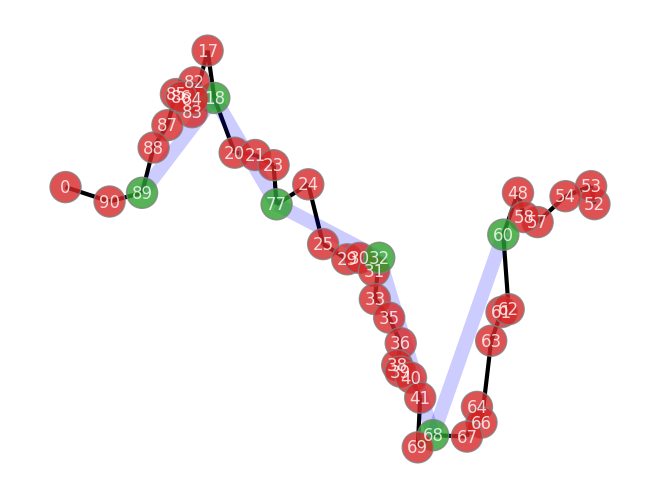

SUMMARY FOR BUDGET OF 10000
objective value:  38228.51958
total costs:  9506.0


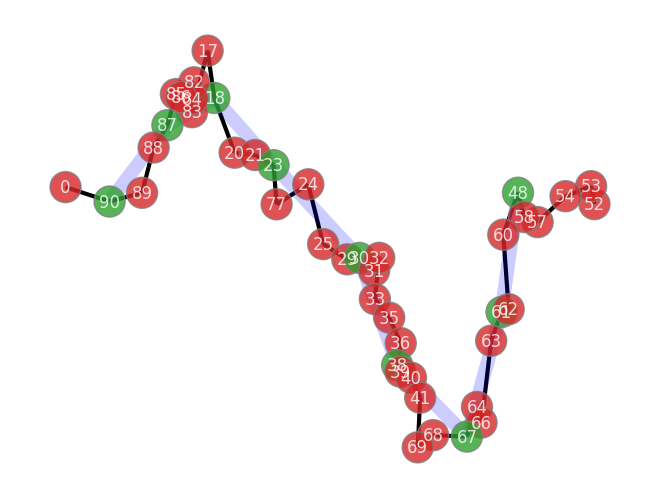

SUMMARY FOR BUDGET OF 15000
objective value:  28056.972876000003
total costs:  14964.0


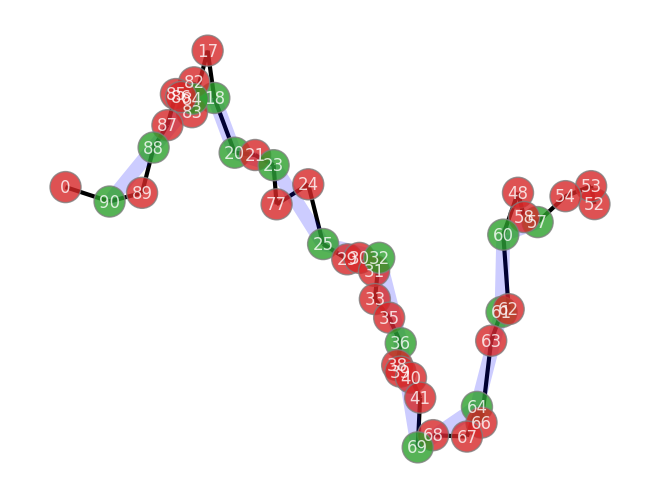

SUMMARY FOR BUDGET OF 25000
objective value:  18119.419498
total costs:  23988.0


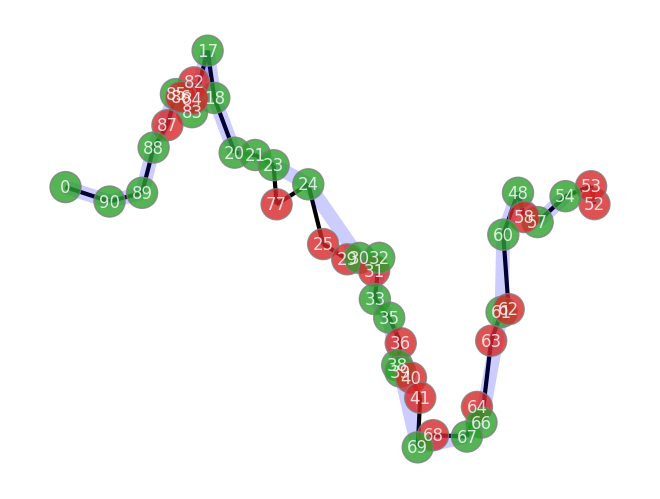

SUMMARY FOR BUDGET OF 45000
objective value:  16011.18979
total costs:  44187.0


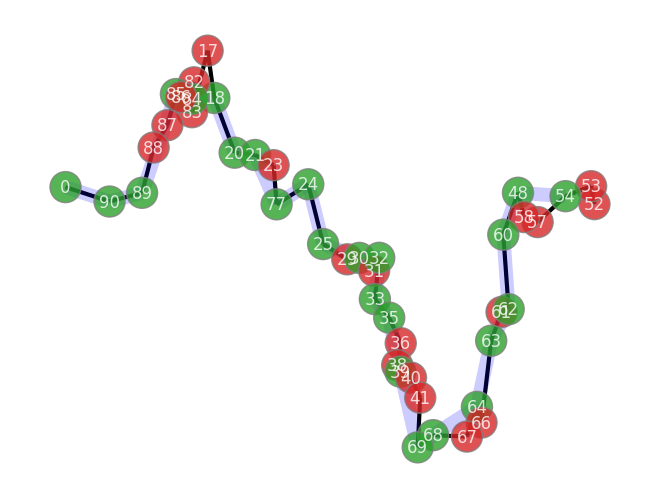

SUMMARY FOR BUDGET OF 95000
objective value:  16011.18979
total costs:  40906.0


In [11]:
def calculate_and_display(budget_list: list, arcs: list, nodes: list, N: list, sol: list)->None:
  for budget in budget_list:
    temp = calculate_model(budget, arcs, nodes, N)
    m = temp['model']
    X = temp['arcs']
    m.optimize()

    # calculate details
    active = set()
    for (i,j) in X:
      if X[(i,j)].x:
        active.add(i)
    costs = 0.
    for el in active:
      costs += c[el]

    # display everything
    values = []
    for i in N:
      if i in active:
        values.append("tab:green")
      else:
        values.append("tab:red")
    g = nx.Graph()
    g.add_nodes_from(N)
    sol_filtered = [x for x in sol if x[0] != -1 and x[1] != -1]
    g.add_edges_from(sol_filtered)
    options = {"edgecolors": "tab:gray", "node_size": 500, "alpha": 0.8}
    nx.draw(g, pos=coord, node_color=values, with_labels=True, font_color='white', **options)
    nx.draw_networkx_edges(g, pos=coord, width=3.0)

    new_arcs = set()
    for (i,j) in X:
      if X[(i,j)].x and i!=-1 and j!=-1:
        new_arcs.add((i,j))
    g = nx.Graph()
    g.add_nodes_from(N)
    g.add_edges_from(new_arcs)
    nx.draw_networkx_edges(g, pos=coord, width=10.0, alpha=0.2, edge_color='Blue')
    plt.show()
    # output a summary
    print("SUMMARY FOR BUDGET OF", budget)
    print('objective value: ', m.objective_value)
    print("total costs: ", costs)

calculate_and_display([10000, 15000, 25000, 45000, 95000], A_dummy, N_dummy, N, sol)

### Parametric analysis

From the previous execution we can actually point out different interesting things:

1. Between a budget of 25000 and 45000 we have found a bottleneck in the optimal result found. In particular we can see that for greater budget we only increase the costs meanwhile the objective function does not decrease.
The most likely cause is that the maximum distance between consecutive stations has been found. To test this hypotesys with the following code we will look for the maximum distance between two consecutive nodes.

In [27]:
# Find the maximum cost between two different
arcs_hash = {(row[0], row[1]): row[2] for row in arcs_np}

max = 0.
for arc in sol_filtered:
  if arcs_hash[arc] > max:
    max = arcs_hash[arc]
    max_arc = arc

print('Longest arc is: ', max_arc, 'with length: ', max)

Longest arc is:  (90.0, 0.0) with length:  16011.18979


>Indeed we found out that the distance between station 0 and 90 that are consecutive is exactly 16011.18979 which is the "saturated" objective value.
The issue is more explicit when we consider that the arc (0,90) is included in the solutions founded for budget > 45000 and thus we have that the objective is bounded by this distance.

2. Knowing the existance of this lower bound to the objective function it may be interesting to see what is the minimum budget that will allow us to obtain the best objective value. In order to do so we slightly modify the previous optimization problem by changing the roles of  variable Y and parameter b.
In fact we now know the optimal value of Y and we want to optimize to find the best b. In the following code boxes we will perform these operations.

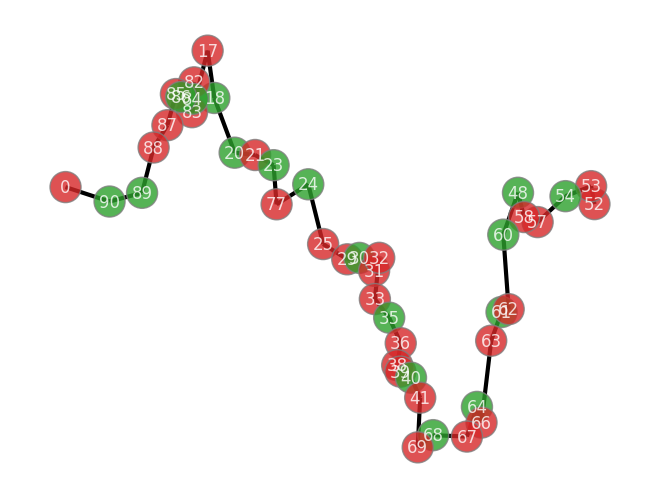

BEST MINIMUM BUDGET FOR OPTIMALITY
minimum budget:  28102.0
total costs:  28102.0
objective value:  16011.18979


In [29]:
def calculate_best_budget(Y: float, arcs: list, nodes: list, N: list):
  # Create model
  m = mip.Model()

  # define the variables

  # The variables of the problem are the edges (couples of consecutive active charging stations)
  X = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in arcs} #empty variables
  b = m.add_var()

  #  define the contraints
  for i in nodes:
    m.add_constr(mip.xsum(X[i,j] for j in nodes)-mip.xsum(X[j,i] for j in nodes)==0) # flow conservation
  # dummy station is active
  m.add_constr(mip.xsum(X[-1,i] for i in N)==1) # arc from dummy to the first node and arc from the last node to dummy needs to be active
  m.add_constr(mip.xsum(X[i,-1] for i in N)==1)
  # Y is limited greater than the maximum distance
  for (i,j) in arcs:
    m.add_constr(X[i,j] * real_distances[(i,j)]<= Y) # the length of every arc in the solution is lessa than Y
  # the budget is met
  m.add_constr(mip.xsum(X[i,j]*c[i] for (i,j) in arcs) <= b) # cost less than budget

  # optimize objective function
  m.objective = mip.minimize(b)

  return {"model": m, "arcs": X}


temp = calculate_best_budget(max, A_dummy, N_dummy, N)
m = temp['model']
X = temp['arcs']
m.optimize()

# calculate details
active = set()
for (i,j) in X:
  if X[(i,j)].x:
    active.add(i)
costs = 0.
for el in active:
  costs += c[el]

# display everything
values = []
for i in N:
  if i in active:
    values.append("tab:green")
  else:
    values.append("tab:red")
g = nx.Graph()
g.add_nodes_from(N)
sol_filtered = [x for x in sol if x[0] != -1 and x[1] != -1]
g.add_edges_from(sol_filtered)
options = {"edgecolors": "tab:gray", "node_size": 500, "alpha": 0.8}
nx.draw(g, pos=coord, node_color=values, with_labels=True, font_color='white', **options)
nx.draw_networkx_edges(g, pos=coord, width=3.0)
plt.show()

# output a summary
print("BEST MINIMUM BUDGET FOR OPTIMALITY")
print('minimum budget: ', m.objective_value)
print("total costs: ", costs)
print("objective value: ", max)

> From this analysis we actually find out that the minimum budget required to obtain the optimal solution is 28102.

In [17]:
ending_time = datetime.now(pytz.timezone('Europe/Rome'))

print('Execution started at:  ', starting_time.isoformat())
print('Execution ended at:    ', ending_time.isoformat())
print('Execution took:        ', str(ending_time - starting_time))

Execution started at:   2024-01-31T20:23:02.424041+01:00
Execution ended at:     2024-01-31T20:23:36.077472+01:00
Execution took:         0:00:33.653431
